# MLP for just the first cases

In [30]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [31]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import numpy as np

In [32]:
path = r'TF_HLC'

In [33]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq_1000.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_1000.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_1000.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

TTF_data = TTF_data
Vs_data = Vs_data

print(TTF_data.shape, Vs_data.shape,freq_data.shape)


(1000, 1000) (1000, 29) (1000,)


In [34]:

#scaler = MaxAbsScaler()
#TTF_values = scaler.fit_transform(TTF_data.T).T
#print(TTF_values.shape)

def normalization(data):
    return np.log10(data)

def denormalization(data):
    return 10**data



Text(0, 0.5, 'TTF [s]')

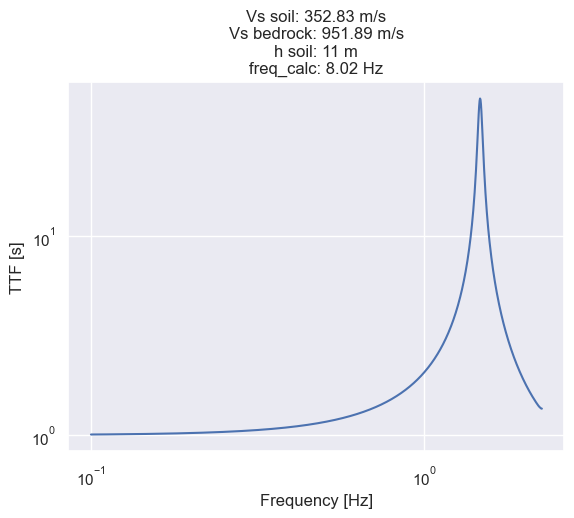

In [35]:
normalized_TTF_data = False

if normalized_TTF_data:
    TTF_values = normalization(TTF_data)
else:
    TTF_values = TTF_data

def text_plot(Vs):
    # Eliminate the nan at the end of the array
    Vs = Vs[~np.isnan(Vs)]
    vs_soil = Vs[0]
    h_soil = len(Vs[:-1])
    vs_bedrock = Vs[-1]
    return f"Vs soil: {vs_soil:.2f} m/s\nVs bedrock: {vs_bedrock:.2f} m/s\nh soil: {h_soil} m\nfreq_calc: {vs_soil/(4*h_soil):.2f} Hz"


idx = 1
plt.loglog(freq_data, TTF_values[idx,:], label="TTF")
plt.title(text_plot(Vs_data[idx,:]))
plt.xlabel("Frequency [Hz]")
plt.ylabel("TTF [s]")
    

In [36]:
# Convert all nan values to 0
Vs = np.nan_to_num(Vs_data, nan=0.0, posinf=0.0, neginf=0.0)

In [37]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = np.nan_to_num(self.Vs_values[idx], nan=0.0, posinf=0.0, neginf=0.0)
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

In [38]:
dataset = TTF_dataset(TTF_values, Vs_data)
print("Sizes in the dataset: ", len(dataset))
print("Data shapes for input and target: ", dataset[0][0].shape, dataset[0][1].shape)

# Separate into training and testing
train_size = int(0.5 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " , train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Sizes in the dataset:  1000
Data shapes for input and target:  torch.Size([29, 1]) torch.Size([1000])
Train, validation and test sizes:  500 250 250
Number of batches:  10 5 5


In [39]:
X,y = next(iter(train_loader))
print(X.shape, y.shape)

torch.Size([50, 29, 1]) torch.Size([50, 1000])


# Model

In [40]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [41]:
class CNN_1D(nn.Module):
    def __init__(self, input_size, kernel_size, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU):
        super(CNN_1D, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Conv1d(input_size, hidden_dim, kernel_size))
        self.hidden_layers.append(nn.MaxPool1d(2))

        # Additional hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Conv1d(hidden_dim, hidden_dim, kernel_size))
            self.hidden_layers.append(nn.MaxPool1d(2))

        # Adaptive pooling layer to reduce sequence length to 1
        self.hidden_layers.append(nn.AdaptiveAvgPool1d(1))

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation()(x)
        return x

In [42]:
# Let's do a RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, device="cpu"):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)   
        out = self.fc(out[:, -1, :])
        return out  

In [43]:
# Sequence-to-sequence model
# Encoder RNN
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, h1 = self.gru(x, h0)
        return out, h1

# Decoder RNN
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.rnn(x, hidden)
        return outputs, hidden

In [44]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(1)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(2, 1)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

In [45]:
class DecoderRNNWithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderRNNWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        rnn_input = torch.cat([x, context], 2)
        outputs, hidden = self.rnn(rnn_input, hidden)
        return outputs, hidden

In [46]:
# Define the Encoder LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (h1, c1) = self.lstm(x, (h0, c0))
        return out, (h1, c1)

class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, (hidden, cell) = self.lstm(x, hidden)
        return outputs, (hidden, cell)

# Define the Decoder LSTM with Attention
class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        h1, c1 = hidden
        attn_weights = self.attention(h1[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        lstm_input = torch.cat([x, context], 2)
        outputs, (hidden, cell) = self.lstm(lstm_input, hidden)
        return outputs, (hidden, cell)


In [47]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        outputs, hidden = self.gru(x)
        return outputs, hidden


class DecoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.gru(x, hidden)
        return outputs, hidden

class DecoderGRUWithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderGRUWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        gru_input = torch.cat([x, context], 2)
        outputs, hidden = self.gru(gru_input, hidden)
        return outputs, hidden

In [48]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        # Concatenate the hidden states from both directions
        hidden = self._cat_directions(hidden)
        cell = self._cat_directions(cell)
        return outputs, (hidden, cell)

    def _cat_directions(self, h):
        # [num_layers * num_directions, batch, hidden_size] -> [num_layers, batch, hidden_size * num_directions]
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
        return h

class DecoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, (hidden, cell) = self.lstm(x, hidden)
        return outputs, (hidden, cell)

In [49]:
class DecoderBiLSTMwithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderBiLSTMwithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        print("x shape: ", x.shape)
        print("hidden shape: ", hidden[0].shape)
        print("encoder_outputs shape: ", encoder_outputs.shape)
        attn_weights = self.attention(hidden[0][-1], encoder_outputs)
        print("attn_weights shape: ", attn_weights.shape)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        lstm_input = torch.cat([x, context], 2)
        outputs, hidden = self.lstm(lstm_input, hidden)
        return outputs, hidden

In [50]:
class EncoderBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderBiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        outputs, hidden = self.gru(x)
        # Concatenate the hidden states from both directions
        hidden = self._cat_directions(hidden)
        return outputs, hidden

    def _cat_directions(self, h):
        # [num_layers * num_directions, batch, hidden_size] -> [num_layers, batch, hidden_size * num_directions]
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
        return h

class DecoderBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderBiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.gru(x, hidden)
        return outputs, hidden

class DecoderBiGRUwithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderBiGRUwithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        gru_input = torch.cat([x, context], 2)
        outputs, hidden = self.gru(gru_input, hidden)
        return outputs, hidden
        

In [51]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, mlp, cnn_1d=None, cnn_1d_out=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mlp = mlp
        self.cnn_1d = cnn_1d
        self.cnn_1d_out = cnn_1d_out

    def forward(self, x, device="cpu", print_shapes=False):
        # Replace Nan values with 0
        x = torch.nan_to_num(x, nan=0.0)


        if print_shapes:
            print("Input shape: ", x.shape)

        if self.cnn_1d:
            x = self.cnn_1d(x)
            if print_shapes:
                print("CNN-in output shape: ", x.shape)
        
        encoder_outputs, hidden = self.encoder(x)
        if print_shapes:
            print("Encoder outputs shape: ", encoder_outputs.shape)
            print("Hidden state shape: ", hidden[0].shape)  # Print hidden state
            print("Cell state shape: ", hidden[1].shape)    # Print cell state
        
        # Adjust decoder input to match encoder hidden size
        if hasattr(self.encoder, 'bidirectional') and self.encoder.bidirectional:
            decoder_input_size = self.encoder.hidden_size * 2
        else:
            decoder_input_size = self.encoder.hidden_size

        decoder_input = torch.zeros(x.size(0), 1, decoder_input_size).to(device)

        if print_shapes:
            print("Decoder input shape: ", decoder_input.shape)
        
        if hasattr(self.decoder, 'attention'):
            output, hidden = self.decoder(decoder_input, hidden, encoder_outputs)
        else:
            output, hidden = self.decoder(decoder_input, hidden)
        
        if print_shapes:
            print("Decoder output shape: ", output.shape)
        
        if self.cnn_1d_out:
            output = self.cnn_1d_out(output)
            output = output.permute(0, 2, 1)
            if print_shapes:
                print("CNN-out output shape: ", output.shape)
        else:
            output = output.squeeze(1)
            if print_shapes:
                print("Squeezed output shape: ", output.shape)

        output = self.mlp(output)

        if print_shapes:
            print("MLP output shape: ", output.shape)
        
        return output.squeeze(1)

In [52]:
# CNN Hyperparameters - In
input_size_cnn = 1
kernel_size = 2
hidden_dim_cnn = 10
hidden_layers_cnn = 2

# CNN Hyperparameters - Out
hidden_dim_cnn_out = 10
hidden_layers_cnn_out = 1


# Encoder and Decoder hyperparameters
input_size = 1 # Given the size of [batch_size, sequence_length, input_size] 
hidden_size = 100
num_layers = 3
encoder_bidirectional = True

# MLP hyperparameters
num_layers_fc = 3
hidden_size_fc = 200
output_size = 1000

# Check bidirectional



In [53]:
# Model
cnn_1d = CNN_1D(input_size_cnn, kernel_size, hidden_dim_cnn, hidden_layers_cnn)
encoder = EncoderBiLSTM(input_size, hidden_size, num_layers)
if hasattr(encoder, 'bidirectional') and encoder.bidirectional:
    hidden_size *= 2
decoder = DecoderLSTMWithAttention(hidden_size, 1, num_layers)
cnn_1d_out = CNN_1D(1, 2, hidden_dim_cnn_out, hidden_layers_cnn_out)
mlp = MLP(200, hidden_size_fc, num_layers_fc, output_size)

model = Seq2Seq(encoder, decoder, mlp, cnn_1d=None, cnn_1d_out=None)

In [54]:
# Check if the model works
X, y = next(iter(train_loader))
print("Input shape: ", X.shape, "Output shape: ", y.shape)
loss_fn = nn.MSELoss()
output = model(X, print_shapes=True)
print("Model output shape: ", output.shape)
assert output.shape == y.shape, "Expected output shape to be the same as target shape"
print(loss_fn(output, y))

Input shape:  torch.Size([50, 29, 1]) Output shape:  torch.Size([50, 1000])
Input shape:  torch.Size([50, 29, 1])
Encoder outputs shape:  torch.Size([50, 29, 200])
Hidden state shape:  torch.Size([3, 50, 200])
Cell state shape:  torch.Size([3, 50, 200])
Decoder input shape:  torch.Size([50, 1, 200])
Decoder output shape:  torch.Size([50, 1, 200])
Squeezed output shape:  torch.Size([50, 200])
MLP output shape:  torch.Size([50, 1000])
Model output shape:  torch.Size([50, 1000])
tensor(29.5955, grad_fn=<MseLossBackward0>)


In [55]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [56]:
from tqdm import trange, tqdm

def train_model(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", 
patience=50, clipping=True, print_epoch=10, normalize=False):
    """
    Train a PyTorch model with early stopping and learning rate scheduler.
    
    Args:
    model: PyTorch model
    optimizer: PyTorch optimizer
    scheduler: PyTorch learning rate scheduler
    train_dataloader: PyTorch DataLoader for training data
    validation_dataloader: PyTorch DataLoader for validation data
    loss_fn: PyTorch loss function
    epochs: Number of epochs to train
    device: PyTorch device, e.g. "cpu" or "cuda"
    patience: Patience for early stopping, i.e. number of epochs without improvement before stopping
    clipping: Whether to use gradient clipping
    print_epoch: Print training and validation loss every print_epoch epochs

    Returns:
    train_losses: List of training losses
    val_losses: List of validation losses
    model: Trained PyTorch model
    """
    
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    save_path = "best_model_RNN.pt"
    best_val_loss = float("inf")

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X, device)
            if normalize:
                y_pred = denormalization(y_pred)
                y = denormalization(y)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X, device)
                if normalize:
                    y_pred = denormalization(y_pred)
                    y = denormalization(y)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with validation loss: {best_val_loss}")

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % print_epoch == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model


def test_model(model, test_dataloader, loss_fn, device="cpu", normalize=False):
    """
    Test a PyTorch model.
    Args:
    model: PyTorch model
    test_dataloader: PyTorch DataLoader for test data
    loss_fn: PyTorch loss function
    device: PyTorch device, e.g. "cpu" or "cuda"
    Returns:
    test_loss: Average test loss
    """
    
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        if normalize:
            y_pred = denormalization(y_pred)
            y = denormalization(y)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [57]:
import torch
import torch.optim as optim
import torch.nn as nn

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4, amsgrad=True, eps=1e-08, betas=(0.7, 0.999))

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=900, 
threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)

# Training
num_epochs = 20000
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = nn.L1Loss()

# Join L1Loss and cosine similarity
def custom_loss(y_true, y_pred, alpha=0.5):
    l1_loss = loss_fn(y_true, y_pred)
    cosine_loss = 1 - torch.nn.functional.cosine_similarity(y_true, y_pred).mean()
    return alpha * l1_loss + (1 - alpha) * cosine_loss

Device:  cuda


In [58]:
train_losses, val_losses, model = train_model(model, optimizer, scheduler, train_loader, val_loader, custom_loss, 
epochs=num_epochs, device=device, patience=1500, clipping=True, print_epoch=1000, normalize=normalized_TTF_data)

Training:   0%|          | 0/20000 [00:00<?, ?epoch/s]

Training:   0%|          | 1/20000 [00:00<2:36:43,  2.13epoch/s]

Best model saved with validation loss: 1.5214138984680177
Epoch 0, Train Loss: 1.7171492099761962, Val Loss: 1.5214138984680177, LR: 0.0005


Training:   0%|          | 2/20000 [00:00<1:48:03,  3.08epoch/s]

Best model saved with validation loss: 1.0069539070129394


Training:   0%|          | 3/20000 [00:00<1:35:48,  3.48epoch/s]

Best model saved with validation loss: 0.960616672039032


Training:   0%|          | 4/20000 [00:01<1:31:03,  3.66epoch/s]

Best model saved with validation loss: 0.9592209696769715


Training:   0%|          | 5/20000 [00:01<1:24:30,  3.94epoch/s]

Best model saved with validation loss: 0.9573137521743774


Training:   0%|          | 6/20000 [00:01<1:23:57,  3.97epoch/s]

Best model saved with validation loss: 0.9571996331214905


Training:   0%|          | 7/20000 [00:01<1:18:33,  4.24epoch/s]

Best model saved with validation loss: 0.9557888984680176


Training:   0%|          | 8/20000 [00:02<1:18:27,  4.25epoch/s]

Best model saved with validation loss: 0.9551328778266907
Best model saved with validation loss: 0.9540634632110596


Training:   0%|          | 11/20000 [00:02<1:14:39,  4.46epoch/s]                                      

Best model saved with validation loss: 0.9537853956222534


Training:   0%|          | 12/20000 [00:02<1:14:58,  4.44epoch/s]

Best model saved with validation loss: 0.9527958989143371


Training:   0%|          | 14/20000 [00:03<1:15:53,  4.39epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.9468409419059753


Training:   0%|          | 16/20000 [00:03<1:14:30,  4.47epoch/s]                                      

Best model saved with validation loss: 0.9114902019500732


Training:   0%|          | 18/20000 [00:04<1:14:23,  4.48epoch/s]                                      

Best model saved with validation loss: 0.9013773202896118


Training:   0%|          | 19/20000 [00:04<1:16:09,  4.37epoch/s]

Best model saved with validation loss: 0.8913376688957214


Training:   0%|          | 20/20000 [00:04<1:14:37,  4.46epoch/s]

Best model saved with validation loss: 0.8899500370025635
Best model saved with validation loss: 0.8816579699516296


Training:   0%|          | 22/20000 [00:05<1:09:28,  4.79epoch/s]

Best model saved with validation loss: 0.8628660440444946
Best model saved with validation loss: 0.8558532476425171


Training:   0%|          | 24/20000 [00:05<1:13:10,  4.55epoch/s]

Best model saved with validation loss: 0.8394824385643005


Training:   0%|          | 25/20000 [00:05<1:14:27,  4.47epoch/s]

Best model saved with validation loss: 0.8327567934989929


Training:   0%|          | 26/20000 [00:06<1:13:02,  4.56epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.8277149319648742


Training:   0%|          | 29/20000 [00:06<1:12:25,  4.60epoch/s]                                      

Best model saved with validation loss: 0.8236220955848694


Training:   0%|          | 30/20000 [00:06<1:16:16,  4.36epoch/s]

Best model saved with validation loss: 0.819842541217804


Training:   0%|          | 31/20000 [00:07<1:15:58,  4.38epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.8036325693130493


Training:   0%|          | 33/20000 [00:07<1:13:14,  4.54epoch/s]                                      

Best model saved with validation loss: 0.7962910294532776


Training:   0%|          | 34/20000 [00:07<1:12:54,  4.56epoch/s]

Best model saved with validation loss: 0.7844496488571167


Training:   0%|          | 35/20000 [00:08<1:12:26,  4.59epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.7699379920959473


Training:   0%|          | 38/20000 [00:08<1:11:52,  4.63epoch/s]                                      

Best model saved with validation loss: 0.7547966122627259


Training:   0%|          | 39/20000 [00:08<1:13:47,  4.51epoch/s]

Best model saved with validation loss: 0.7441545724868774


Training:   0%|          | 41/20000 [00:09<1:15:38,  4.40epoch/s]                                      

Best model saved with validation loss: 0.7288102984428406


Training:   0%|          | 42/20000 [00:09<1:16:22,  4.36epoch/s]

Best model saved with validation loss: 0.7284387588500977


Training:   0%|          | 43/20000 [00:09<1:23:04,  4.00epoch/s]

Best model saved with validation loss: 0.7177993059158325


Training:   0%|          | 44/20000 [00:10<1:25:32,  3.89epoch/s]

Best model saved with validation loss: 0.7166280269622802


Training:   0%|          | 45/20000 [00:10<1:24:43,  3.93epoch/s]

Best model saved with validation loss: 0.7099086523056031


Training:   0%|          | 46/20000 [00:10<1:38:44,  3.37epoch/s]

Best model saved with validation loss: 0.6983936071395874


Training:   0%|          | 48/20000 [00:11<1:39:58,  3.33epoch/s]                                      

Best model saved with validation loss: 0.695447838306427
Best model saved with validation loss: 0.6924133419990539


Training:   0%|          | 50/20000 [00:11<1:36:47,  3.44epoch/s]

Best model saved with validation loss: 0.6898391127586365


Training:   0%|          | 53/20000 [00:12<1:26:36,  3.84epoch/s]                                      

Best model saved with validation loss: 0.6864259362220764


Training:   0%|          | 55/20000 [00:13<1:15:44,  4.39epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.6802910685539245


Training:   0%|          | 59/20000 [00:13<1:07:41,  4.91epoch/s]                                      

Best model saved with validation loss: 0.6683300971984864
Best model saved with validation loss: 0.6567975044250488


Training:   0%|          | 60/20000 [00:14<1:06:48,  4.97epoch/s]

Best model saved with validation loss: 0.6547396659851075
Best model saved with validation loss: 0.6511201739311219


Training:   0%|          | 63/20000 [00:14<1:02:47,  5.29epoch/s]                                      

Best model saved with validation loss: 0.6434104800224304
Best model saved with validation loss: 0.6389985918998718


Training:   0%|          | 67/20000 [00:15<1:04:32,  5.15epoch/s]                                      

Best model saved with validation loss: 0.6387444138526917


Training:   0%|          | 68/20000 [00:15<1:05:46,  5.05epoch/s]

Best model saved with validation loss: 0.6360780477523804
Best model saved with validation loss: 0.6272189021110535


Training:   0%|          | 70/20000 [00:16<1:05:52,  5.04epoch/s]

Best model saved with validation loss: 0.6267600536346436


Training:   0%|          | 74/20000 [00:17<1:12:14,  4.60epoch/s]                                      

Best model saved with validation loss: 0.620531415939331
Best model saved with validation loss: 0.6154349684715271


Training:   0%|          | 77/20000 [00:17<1:17:45,  4.27epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.6125584959983825


Training:   0%|          | 79/20000 [00:18<1:12:38,  4.57epoch/s]                                      

Best model saved with validation loss: 0.6042767882347106


Training:   0%|          | 81/20000 [00:18<1:16:41,  4.33epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.6041248083114624


Training:   0%|          | 83/20000 [00:18<1:11:51,  4.62epoch/s]                                      

Best model saved with validation loss: 0.5966179728507995


Training:   0%|          | 84/20000 [00:19<1:16:57,  4.31epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.5930650711059571


Training:   0%|          | 88/20000 [00:20<1:13:54,  4.49epoch/s]                                      

Best model saved with validation loss: 0.592168653011322


Training:   0%|          | 89/20000 [00:20<1:16:21,  4.35epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.5872727990150451


Training:   0%|          | 95/20000 [00:21<1:01:44,  5.37epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.5825976014137269


Training:   0%|          | 97/20000 [00:21<1:06:18,  5.00epoch/s]                                      

Best model saved with validation loss: 0.5811242699623108


Training:   0%|          | 98/20000 [00:22<1:14:50,  4.43epoch/s]

Best model saved with validation loss: 0.5758465766906739


Training:   1%|          | 104/20000 [00:23<1:09:54,  4.74epoch/s]                                      

Best model saved with validation loss: 0.5727682709693909


Training:   1%|          | 107/20000 [00:23<1:08:12,  4.86epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.56833416223526


Training:   1%|          | 110/20000 [00:24<1:08:49,  4.82epoch/s]                                      

Best model saved with validation loss: 0.5676355481147766
Best model saved with validation loss: 0.5644320487976074


Training:   1%|          | 115/20000 [00:25<1:11:57,  4.61epoch/s]                                      

Best model saved with validation loss: 0.5595523834228515


Training:   1%|          | 116/20000 [00:25<1:13:00,  4.54epoch/s]

Best model saved with validation loss: 0.558128297328949


Training:   1%|          | 120/20000 [00:26<1:11:23,  4.64epoch/s]                                      

Best model saved with validation loss: 0.556660532951355


Training:   1%|          | 127/20000 [00:28<1:04:52,  5.11epoch/s]                                      

Best model saved with validation loss: 0.5532894015312195


Training:   1%|          | 128/20000 [00:28<1:08:12,  4.86epoch/s]

Best model saved with validation loss: 0.5520932018756867
Best model saved with validation loss: 0.5495685935020447


Training:   1%|          | 132/20000 [00:29<1:06:31,  4.98epoch/s]                                      

Best model saved with validation loss: 0.5419434785842896
Best model saved with validation loss: 0.5401240050792694


Training:   1%|          | 143/20000 [00:31<1:03:19,  5.23epoch/s]                                      

Best model saved with validation loss: 0.5390208840370179


Training:   1%|          | 150/20000 [00:32<1:11:18,  4.64epoch/s]                                      

Best model saved with validation loss: 0.5339246809482574
Best model saved with validation loss: 0.5313006520271302


Training:   1%|          | 159/20000 [00:34<1:07:26,  4.90epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.5265305399894714


Training:   1%|          | 164/20000 [00:35<1:11:43,  4.61epoch/s]                                      

Best model saved with validation loss: 0.5223641514778137


Training:   1%|          | 168/20000 [00:36<1:09:46,  4.74epoch/s]                                      

Best model saved with validation loss: 0.5221381068229676


Training:   1%|          | 169/20000 [00:36<1:11:27,  4.62epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.5184766352176666


Training:   1%|          | 174/20000 [00:37<1:11:10,  4.64epoch/s]                                      

Best model saved with validation loss: 0.5183126270771027


Training:   1%|          | 175/20000 [00:38<1:13:33,  4.49epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.5121687650680542


Training:   1%|          | 180/20000 [00:38<1:04:26,  5.13epoch/s]                                      

Best model saved with validation loss: 0.5108143210411071
Best model saved with validation loss: 0.5078386843204499


Training:   1%|          | 187/20000 [00:40<1:07:29,  4.89epoch/s]                                      

Best model saved with validation loss: 0.5051602125167847


Training:   1%|          | 189/20000 [00:40<1:05:38,  5.03epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.5046629667282104


Training:   1%|          | 190/20000 [00:40<1:04:02,  5.16epoch/s]                                      

Best model saved with validation loss: 0.5020500600337983


Training:   1%|          | 198/20000 [00:42<1:07:47,  4.87epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.49920480847358706


Training:   1%|          | 203/20000 [00:43<1:09:41,  4.73epoch/s]                                      

Best model saved with validation loss: 0.493093341588974


Training:   1%|          | 210/20000 [00:44<1:04:56,  5.08epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.49020127654075624


Training:   1%|          | 219/20000 [00:46<1:03:23,  5.20epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.4888290286064148


Training:   1%|          | 226/20000 [00:47<58:47,  5.61epoch/s]                                        

Best model saved with validation loss: 0.4807668924331665


Training:   1%|          | 228/20000 [00:48<1:00:56,  5.41epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.4797717213630676


Training:   1%|          | 235/20000 [00:49<1:01:26,  5.36epoch/s]                                      

Best model saved with validation loss: 0.47873883247375487


Training:   1%|          | 245/20000 [00:51<1:00:56,  5.40epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.4764218032360077


Training:   1%|▏         | 250/20000 [00:52<1:03:40,  5.17epoch/s]                                      

Best model saved with validation loss: 0.4714226365089417


Training:   1%|▏         | 261/20000 [00:54<1:10:05,  4.69epoch/s]                                       

Best model saved with validation loss: 0.4701752126216888


Training:   1%|▏         | 262/20000 [00:55<1:11:14,  4.62epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.46718186140060425


Training:   1%|▏         | 264/20000 [00:55<1:09:47,  4.71epoch/s]                                      

Best model saved with validation loss: 0.46632264256477357


Training:   1%|▏         | 267/20000 [00:55<1:06:10,  4.97epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.4638992965221405


Training:   1%|▏         | 268/20000 [00:56<1:09:56,  4.70epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.4603956162929535


Training:   1%|▏         | 276/20000 [00:57<1:07:36,  4.86epoch/s]                                      

Best model saved with validation loss: 0.4570919394493103


Training:   1%|▏         | 279/20000 [00:58<1:16:02,  4.32epoch/s]                                      

Best model saved with validation loss: 0.4539353847503662


Training:   1%|▏         | 281/20000 [00:58<1:08:13,  4.82epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.4537384629249573


Training:   1%|▏         | 288/20000 [01:00<1:04:33,  5.09epoch/s]                                      

Best model saved with validation loss: 0.4536032736301422


Training:   1%|▏         | 289/20000 [01:00<1:06:36,  4.93epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.4516604900360107


Training:   1%|▏         | 297/20000 [01:02<1:06:34,  4.93epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.4493930160999298


Training:   2%|▏         | 301/20000 [01:02<1:08:03,  4.82epoch/s]                                      

Best model saved with validation loss: 0.4458149313926697


Training:   2%|▏         | 303/20000 [01:03<1:13:43,  4.45epoch/s]                                      

Best model saved with validation loss: 0.44180627465248107
Best model saved with validation loss: 0.44141229391098025


Training:   2%|▏         | 311/20000 [01:05<1:05:29,  5.01epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.43728742003440857


Training:   2%|▏         | 326/20000 [01:08<1:01:54,  5.30epoch/s, EarlyStopping counter: 1 out of 1500] 

Best model saved with validation loss: 0.4282146871089935


Training:   2%|▏         | 328/20000 [01:08<1:03:41,  5.15epoch/s]                                      

Best model saved with validation loss: 0.4279740035533905


Training:   2%|▏         | 329/20000 [01:08<1:06:39,  4.92epoch/s]

Best model saved with validation loss: 0.4244643568992615


Training:   2%|▏         | 334/20000 [01:10<1:11:24,  4.59epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.42401900291442873


Training:   2%|▏         | 337/20000 [01:10<1:07:25,  4.86epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.4228106915950775


Training:   2%|▏         | 339/20000 [01:10<1:10:03,  4.68epoch/s]                                      

Best model saved with validation loss: 0.4214970409870148


Training:   2%|▏         | 342/20000 [01:11<1:18:21,  4.18epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.42082724571228025


Training:   2%|▏         | 355/20000 [01:14<1:08:32,  4.78epoch/s, EarlyStopping counter: 1 out of 1500] 

Best model saved with validation loss: 0.4181714832782745


Training:   2%|▏         | 361/20000 [01:15<1:08:40,  4.77epoch/s]                                      

Best model saved with validation loss: 0.4122553110122681


Training:   2%|▏         | 376/20000 [01:18<1:06:04,  4.95epoch/s]                                       

Best model saved with validation loss: 0.40974263548851014
Best model saved with validation loss: 0.40747734904289246


Training:   2%|▏         | 378/20000 [01:18<1:00:50,  5.37epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.40420623421669005


Training:   2%|▏         | 387/20000 [01:20<1:00:33,  5.40epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.40379015207290647


Training:   2%|▏         | 388/20000 [01:20<1:02:49,  5.20epoch/s]                                      

Best model saved with validation loss: 0.40228267312049865


Training:   2%|▏         | 404/20000 [01:24<1:10:14,  4.65epoch/s]                                       

Best model saved with validation loss: 0.40124048590660094
Best model saved with validation loss: 0.3997712016105652


Training:   2%|▏         | 406/20000 [01:24<1:16:25,  4.27epoch/s]

Best model saved with validation loss: 0.3989281952381134


Training:   2%|▏         | 408/20000 [01:25<1:12:11,  4.52epoch/s]                                      

Best model saved with validation loss: 0.3986805021762848


Training:   2%|▏         | 413/20000 [01:26<1:03:08,  5.17epoch/s]                                      

Best model saved with validation loss: 0.39851178526878356


Training:   2%|▏         | 415/20000 [01:26<1:03:36,  5.13epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.39698356986045835


Training:   2%|▏         | 421/20000 [01:27<1:01:48,  5.28epoch/s]                                      

Best model saved with validation loss: 0.3963144302368164


Training:   2%|▏         | 458/20000 [01:34<57:56,  5.62epoch/s, EarlyStopping counter: 1 out of 1500]   

Best model saved with validation loss: 0.39197850227355957


Training:   2%|▏         | 459/20000 [01:35<58:41,  5.55epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.39062777161598206


Training:   2%|▏         | 467/20000 [01:36<1:01:59,  5.25epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.3901943385601044


Training:   2%|▏         | 485/20000 [01:40<1:04:54,  5.01epoch/s]                                       

Best model saved with validation loss: 0.3900075614452362


Training:   3%|▎         | 511/20000 [01:45<1:07:15,  4.83epoch/s]                                       

Best model saved with validation loss: 0.38605462908744814


Training:   3%|▎         | 555/20000 [01:54<1:03:02,  5.14epoch/s]                                       

Best model saved with validation loss: 0.3844016373157501


Training:   3%|▎         | 579/20000 [01:58<59:28,  5.44epoch/s]                                         

Best model saved with validation loss: 0.3826328933238983
Best model saved with validation loss: 0.38168691396713256


Training:   3%|▎         | 607/20000 [02:04<1:00:23,  5.35epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.3808615505695343


Training:   3%|▎         | 609/20000 [02:04<1:00:47,  5.32epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.378323632478714


Training:   3%|▎         | 642/20000 [02:10<59:24,  5.43epoch/s, EarlyStopping counter: 1 out of 1500]  

Best model saved with validation loss: 0.3751873552799225


Training:   3%|▎         | 646/20000 [02:10<1:05:38,  4.91epoch/s]                                      

Best model saved with validation loss: 0.3739497125148773


Training:   3%|▎         | 666/20000 [02:14<58:58,  5.46epoch/s, EarlyStopping counter: 1 out of 1500]   

Best model saved with validation loss: 0.3730126261711121


Training:   4%|▎         | 712/20000 [02:23<1:06:22,  4.84epoch/s]                                       

Best model saved with validation loss: 0.3703771770000458


Training:   4%|▎         | 714/20000 [02:24<1:06:09,  4.86epoch/s]                                      

Best model saved with validation loss: 0.36746317744255064


Training:   4%|▎         | 716/20000 [02:24<1:06:22,  4.84epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.3664524734020233


Training:   4%|▎         | 724/20000 [02:26<1:01:41,  5.21epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.3657861053943634


Training:   4%|▎         | 729/20000 [02:27<1:09:14,  4.64epoch/s]                                      

Best model saved with validation loss: 0.3648202955722809


Training:   4%|▎         | 735/20000 [02:28<1:05:36,  4.89epoch/s]                                      

Best model saved with validation loss: 0.3631923317909241


Training:   4%|▍         | 758/20000 [02:33<1:06:11,  4.85epoch/s, EarlyStopping counter: 1 out of 1500] 

Best model saved with validation loss: 0.3616970837116241


Training:   4%|▍         | 761/20000 [02:34<1:15:46,  4.23epoch/s]                                      

Best model saved with validation loss: 0.3615202963352203


Training:   4%|▍         | 765/20000 [02:35<1:17:54,  4.11epoch/s]                                      

Best model saved with validation loss: 0.35992435812950135


Training:   4%|▍         | 778/20000 [02:38<1:07:27,  4.75epoch/s]                                       

Best model saved with validation loss: 0.35975106358528136


Training:   4%|▍         | 796/20000 [02:42<1:14:14,  4.31epoch/s]                                       

Best model saved with validation loss: 0.3581564903259277


Training:   4%|▍         | 816/20000 [02:46<1:06:09,  4.83epoch/s]                                       

Best model saved with validation loss: 0.3565578103065491


Training:   4%|▍         | 824/20000 [02:47<55:57,  5.71epoch/s, EarlyStopping counter: 1 out of 1500]  

Best model saved with validation loss: 0.35653469562530515


Training:   4%|▍         | 828/20000 [02:48<58:56,  5.42epoch/s, EarlyStopping counter: 1 out of 1500]

Best model saved with validation loss: 0.3558103680610657


Training:   4%|▍         | 843/20000 [02:52<1:36:05,  3.32epoch/s]                                       

Best model saved with validation loss: 0.35368465781211855


Training:   4%|▍         | 860/20000 [02:56<1:22:22,  3.87epoch/s]                                       

Best model saved with validation loss: 0.34888840317726133


Training:   4%|▍         | 861/20000 [02:57<1:40:37,  3.17epoch/s]

Best model saved with validation loss: 0.3475613594055176


Training:   4%|▍         | 893/20000 [07:30<2:49:36,  1.88epoch/s]                                        

Best model saved with validation loss: 0.3452582836151123


Training:   4%|▍         | 899/20000 [07:33<2:56:54,  1.80epoch/s]                                      

Best model saved with validation loss: 0.34462366700172425


Training:   5%|▍         | 902/20000 [07:35<2:43:01,  1.95epoch/s]                                      

Best model saved with validation loss: 0.342288613319397


Training:   5%|▍         | 914/20000 [07:40<2:24:59,  2.19epoch/s]                                       

Best model saved with validation loss: 0.3394560396671295


Training:   5%|▍         | 944/20000 [07:49<1:24:58,  3.74epoch/s]                                       

Best model saved with validation loss: 0.3366142749786377


Training:   5%|▍         | 998/20000 [08:03<1:22:25,  3.84epoch/s]                                       

Best model saved with validation loss: 0.3347437918186188


Training:   5%|▍         | 999/20000 [08:03<1:25:09,  3.72epoch/s]

Best model saved with validation loss: 0.3334117352962494


Training:   5%|▌         | 1001/20000 [08:04<1:30:36,  3.49epoch/s, EarlyStopping counter: 2 out of 1500]

Epoch 1000, Train Loss: 0.29385483264923096, Val Loss: 0.3350635409355164, LR: 0.0005


Training:   5%|▌         | 1025/20000 [08:10<1:23:19,  3.80epoch/s]                                       

Best model saved with validation loss: 0.3318320751190186


Training:   5%|▌         | 1028/20000 [08:11<1:21:23,  3.88epoch/s]                                      

Best model saved with validation loss: 0.3310263991355896


Training:   5%|▌         | 1029/20000 [08:12<1:31:46,  3.45epoch/s]

Best model saved with validation loss: 0.33095875978469846


Training:   5%|▌         | 1039/20000 [08:14<1:32:26,  3.42epoch/s]                                      

Best model saved with validation loss: 0.3278486728668213


Training:   5%|▌         | 1040/20000 [08:15<1:32:37,  3.41epoch/s]

Best model saved with validation loss: 0.32635916471481324


Training:   6%|▌         | 1101/20000 [08:30<1:18:25,  4.02epoch/s]                                       

Best model saved with validation loss: 0.3249847531318665


Training:   6%|▌         | 1103/20000 [08:31<1:22:52,  3.80epoch/s]                                      

Best model saved with validation loss: 0.32287971377372743


Training:   6%|▌         | 1108/20000 [08:32<1:30:09,  3.49epoch/s]                                      

Best model saved with validation loss: 0.3216032743453979


Training:   6%|▌         | 1146/20000 [08:43<1:25:05,  3.69epoch/s]                                       

Best model saved with validation loss: 0.3213192462921143


Training:   6%|▌         | 1164/20000 [08:48<1:27:34,  3.58epoch/s]                                       

Best model saved with validation loss: 0.3199973702430725


Training:   6%|▌         | 1168/20000 [08:49<1:29:21,  3.51epoch/s]                                      

Best model saved with validation loss: 0.31710928678512573


Training:   6%|▌         | 1173/20000 [08:50<1:25:05,  3.69epoch/s]                                      

Best model saved with validation loss: 0.3137370407581329


Training:   6%|▌         | 1193/20000 [08:55<1:22:25,  3.80epoch/s]                                       

Best model saved with validation loss: 0.310201358795166


Training:   6%|▌         | 1221/20000 [09:03<1:29:18,  3.50epoch/s]                                       

Best model saved with validation loss: 0.31008973717689514


Training:   6%|▌         | 1223/20000 [09:03<1:27:34,  3.57epoch/s]                                      

Best model saved with validation loss: 0.30710193514823914


Training:   6%|▌         | 1242/20000 [09:08<1:19:57,  3.91epoch/s]                                       

Best model saved with validation loss: 0.30474175214767457


Training:   6%|▋         | 1261/20000 [09:13<1:22:15,  3.80epoch/s]                                       

Best model saved with validation loss: 0.3047287821769714


Training:   6%|▋         | 1287/20000 [09:20<1:29:39,  3.48epoch/s]                                       

Best model saved with validation loss: 0.30096185207366943


Training:   6%|▋         | 1298/20000 [09:23<1:27:08,  3.58epoch/s]                                       

Best model saved with validation loss: 0.29947667717933657


Training:   7%|▋         | 1325/20000 [09:31<1:27:36,  3.55epoch/s]                                       

Best model saved with validation loss: 0.2977177619934082


Training:   7%|▋         | 1348/20000 [09:37<1:28:04,  3.53epoch/s]                                       

Best model saved with validation loss: 0.2952551245689392


Training:   7%|▋         | 1368/20000 [09:43<1:25:09,  3.65epoch/s]                                       

Best model saved with validation loss: 0.2945777416229248


Training:   7%|▋         | 1406/20000 [09:53<1:24:35,  3.66epoch/s]                                       

Best model saved with validation loss: 0.2926503360271454


Training:   7%|▋         | 1408/20000 [09:53<1:23:44,  3.70epoch/s]                                      

Best model saved with validation loss: 0.2913093388080597


Training:   7%|▋         | 1410/20000 [09:54<1:28:19,  3.51epoch/s]                                      

Best model saved with validation loss: 0.29081267714500425


Training:   7%|▋         | 1434/20000 [10:00<1:20:28,  3.85epoch/s]                                       

Best model saved with validation loss: 0.2905089735984802


Training:   7%|▋         | 1464/20000 [10:09<1:31:55,  3.36epoch/s]                                       

Best model saved with validation loss: 0.28824108839035034


Training:   7%|▋         | 1471/20000 [10:11<1:22:07,  3.76epoch/s]                                      

Best model saved with validation loss: 0.2872998297214508


Training:   7%|▋         | 1478/20000 [10:13<1:25:27,  3.61epoch/s]                                      

Best model saved with validation loss: 0.28705544471740724


Training:   8%|▊         | 1504/20000 [10:20<1:21:15,  3.79epoch/s]                                       

Best model saved with validation loss: 0.2868121266365051


Training:   8%|▊         | 1517/20000 [10:23<1:18:53,  3.90epoch/s]                                       

Best model saved with validation loss: 0.2835842490196228


Training:   8%|▊         | 1519/20000 [10:24<1:26:35,  3.56epoch/s]                                      

Best model saved with validation loss: 0.28205791115760803


Training:   8%|▊         | 1525/20000 [10:25<1:20:21,  3.83epoch/s]                                      

Best model saved with validation loss: 0.28177143931388854


Training:   8%|▊         | 1534/20000 [10:28<1:25:38,  3.59epoch/s]                                      

Best model saved with validation loss: 0.281203156709671


Training:   8%|▊         | 1544/20000 [10:30<1:15:52,  4.05epoch/s]                                      

Best model saved with validation loss: 0.2807233273983002


Training:   8%|▊         | 1556/20000 [10:33<1:21:31,  3.77epoch/s]                                       

Best model saved with validation loss: 0.2799252957105637


Training:   8%|▊         | 1587/20000 [10:41<1:16:28,  4.01epoch/s]                                       

Best model saved with validation loss: 0.27992257475852966


Training:   8%|▊         | 1589/20000 [10:42<1:19:32,  3.86epoch/s]                                      

Best model saved with validation loss: 0.279047292470932


Training:   8%|▊         | 1666/20000 [11:02<1:15:14,  4.06epoch/s]                                       

Best model saved with validation loss: 0.27821111083030703


Training:   8%|▊         | 1667/20000 [11:03<1:18:00,  3.92epoch/s]

Best model saved with validation loss: 0.27750058472156525


Training:   8%|▊         | 1671/20000 [11:04<1:21:02,  3.77epoch/s]                                      

Best model saved with validation loss: 0.27623063027858735


Training:   9%|▊         | 1722/20000 [11:17<1:27:41,  3.47epoch/s]                                       

Best model saved with validation loss: 0.2737268030643463


Training:   9%|▉         | 1846/20000 [11:48<1:19:13,  3.82epoch/s]                                        

Best model saved with validation loss: 0.2714390754699707


Training:  10%|▉         | 1959/20000 [12:37<2:32:00,  1.98epoch/s]                                        

Best model saved with validation loss: 0.2698552668094635


Training:  10%|█         | 2001/20000 [12:56<2:27:02,  2.04epoch/s]                                       

Best model saved with validation loss: 0.2695347428321838
Epoch 2000, Train Loss: 0.22729913592338563, Val Loss: 0.2695347428321838, LR: 0.0005


Training:  10%|█         | 2056/20000 [13:21<2:26:19,  2.04epoch/s]                                       

Best model saved with validation loss: 0.2674381732940674


Training:  11%|█         | 2184/20000 [14:02<1:12:22,  4.10epoch/s]                                        

Best model saved with validation loss: 0.26448634564876555


Training:  11%|█         | 2206/20000 [14:08<1:12:54,  4.07epoch/s]                                       

Best model saved with validation loss: 0.2634857714176178


Training:  11%|█▏        | 2258/20000 [14:21<1:20:19,  3.68epoch/s]                                       

Best model saved with validation loss: 0.2624643951654434


Training:  11%|█▏        | 2285/20000 [14:29<1:21:57,  3.60epoch/s]                                       

Best model saved with validation loss: 0.26155966222286225


Training:  11%|█▏        | 2286/20000 [14:29<1:23:13,  3.55epoch/s]

Best model saved with validation loss: 0.2605767101049423


Training:  12%|█▏        | 2341/20000 [14:43<1:10:55,  4.15epoch/s]                                       

Best model saved with validation loss: 0.2602784872055054


Training:  12%|█▏        | 2361/20000 [14:48<1:15:13,  3.91epoch/s]                                       

Best model saved with validation loss: 0.25923666059970857


Training:  12%|█▏        | 2362/20000 [14:48<1:17:24,  3.80epoch/s]

Best model saved with validation loss: 0.25865626633167266


Training:  12%|█▏        | 2419/20000 [15:03<1:13:35,  3.98epoch/s]                                       

Best model saved with validation loss: 0.2538337469100952


Training:  12%|█▏        | 2465/20000 [15:14<1:12:40,  4.02epoch/s]                                       

Best model saved with validation loss: 0.25246956944465637


Training:  13%|█▎        | 2532/20000 [15:32<1:19:21,  3.67epoch/s]                                       

Best model saved with validation loss: 0.25073888897895813


Training:  13%|█▎        | 2544/20000 [15:35<1:21:43,  3.56epoch/s]                                       

Best model saved with validation loss: 0.2503227531909943


Training:  13%|█▎        | 2589/20000 [15:46<1:12:14,  4.02epoch/s]                                       

Best model saved with validation loss: 0.24935376048088073


Training:  13%|█▎        | 2593/20000 [15:47<1:13:04,  3.97epoch/s]                                      

Best model saved with validation loss: 0.2489630699157715


Training:  13%|█▎        | 2633/20000 [16:00<2:06:03,  2.30epoch/s]                                       

Best model saved with validation loss: 0.24813522398471832


Training:  13%|█▎        | 2636/20000 [16:02<2:12:29,  2.18epoch/s]                                      

Best model saved with validation loss: 0.24481038451194764


Training:  14%|█▎        | 2712/20000 [16:30<2:19:53,  2.06epoch/s]                                       

Best model saved with validation loss: 0.24414772391319275


Training:  14%|█▎        | 2727/20000 [16:37<2:21:42,  2.03epoch/s]                                       

Best model saved with validation loss: 0.24336857497692108


Training:  14%|█▍        | 2785/20000 [17:04<2:18:29,  2.07epoch/s]                                       

Best model saved with validation loss: 0.24112916588783265


Training:  14%|█▍        | 2875/20000 [17:48<2:21:05,  2.02epoch/s]                                       

Best model saved with validation loss: 0.23751554191112517


Training:  14%|█▍        | 2887/20000 [17:54<2:07:40,  2.23epoch/s]                                       

Best model saved with validation loss: 0.2353444814682007


Training:  15%|█▍        | 2906/20000 [17:59<1:17:28,  3.68epoch/s]                                       

Best model saved with validation loss: 0.23506356179714202


Training:  15%|█▍        | 2941/20000 [18:09<1:22:35,  3.44epoch/s]                                       

Best model saved with validation loss: 0.23394564986228944


Training:  15%|█▌        | 3001/20000 [18:26<1:11:30,  3.96epoch/s, EarlyStopping counter: 60 out of 1500]

Epoch 3000, Train Loss: 0.20131799727678298, Val Loss: 0.2659760892391205, LR: 0.0005


Training:  15%|█▌        | 3046/20000 [18:39<1:15:14,  3.76epoch/s]                                        

Best model saved with validation loss: 0.2337006688117981


Training:  15%|█▌        | 3053/20000 [18:40<1:16:29,  3.69epoch/s]                                      

Best model saved with validation loss: 0.23280787467956543


Training:  15%|█▌        | 3070/20000 [18:46<1:55:10,  2.45epoch/s]                                       

Best model saved with validation loss: 0.23217682242393495


Training:  16%|█▌        | 3105/20000 [18:55<1:16:50,  3.66epoch/s]                                       

Best model saved with validation loss: 0.22972016036510468


Training:  16%|█▌        | 3202/20000 [19:21<1:18:00,  3.59epoch/s]                                       

Best model saved with validation loss: 0.22912167608737946


Training:  16%|█▌        | 3243/20000 [19:32<1:17:16,  3.61epoch/s]                                       

Best model saved with validation loss: 0.22849363684654236


Training:  16%|█▋        | 3288/20000 [19:44<1:13:08,  3.81epoch/s]                                       

Best model saved with validation loss: 0.22785374522209167


Training:  16%|█▋        | 3294/20000 [19:46<1:16:29,  3.64epoch/s]                                      

Best model saved with validation loss: 0.22640379667282104


Training:  17%|█▋        | 3305/20000 [19:49<1:16:26,  3.64epoch/s]                                       

Best model saved with validation loss: 0.22628694474697114


Training:  17%|█▋        | 3358/20000 [20:03<1:17:06,  3.60epoch/s]                                       

Best model saved with validation loss: 0.22529680728912355


Training:  17%|█▋        | 3364/20000 [20:05<1:19:36,  3.48epoch/s]                                      

Best model saved with validation loss: 0.221800097823143


Training:  17%|█▋        | 3440/20000 [20:31<2:01:55,  2.26epoch/s]                                       

Best model saved with validation loss: 0.22164106070995332


Training:  17%|█▋        | 3444/20000 [20:33<2:12:55,  2.08epoch/s]                                      

Best model saved with validation loss: 0.21944900453090668


Training:  18%|█▊        | 3506/20000 [21:01<2:03:27,  2.23epoch/s]                                       

Best model saved with validation loss: 0.21758963763713837


Training:  18%|█▊        | 3573/20000 [21:31<2:08:41,  2.13epoch/s]                                       

Best model saved with validation loss: 0.21708966195583343


Training:  19%|█▉        | 3788/20000 [23:07<1:59:30,  2.26epoch/s]                                        

Best model saved with validation loss: 0.21456945538520814


Training:  20%|█▉        | 3905/20000 [23:59<2:03:44,  2.17epoch/s]                                        

Best model saved with validation loss: 0.2141820013523102


Training:  20%|██        | 4001/20000 [24:41<1:46:32,  2.50epoch/s, EarlyStopping counter: 96 out of 1500]

Epoch 4000, Train Loss: 0.1537234976887703, Val Loss: 0.2201961874961853, LR: 0.0005


Training:  20%|██        | 4008/20000 [24:44<2:02:26,  2.18epoch/s]                                        

Best model saved with validation loss: 0.21391410231590272


Training:  21%|██        | 4111/20000 [25:29<1:57:30,  2.25epoch/s]                                        

Best model saved with validation loss: 0.21304894387722015


Training:  21%|██▏       | 4296/20000 [26:52<1:51:54,  2.34epoch/s]                                        

Best model saved with validation loss: 0.2121461421251297


Training:  22%|██▏       | 4334/20000 [27:09<2:00:13,  2.17epoch/s]                                       

Best model saved with validation loss: 0.2120085209608078


Training:  22%|██▏       | 4349/20000 [27:15<1:57:55,  2.21epoch/s]                                       

Best model saved with validation loss: 0.21062412858009338


Training:  22%|██▏       | 4453/20000 [27:58<1:56:43,  2.22epoch/s]                                        

Best model saved with validation loss: 0.21000972986221314


Training:  22%|██▏       | 4483/20000 [28:11<1:53:18,  2.28epoch/s]                                       

Best model saved with validation loss: 0.20876110792160035


Training:  23%|██▎       | 4551/20000 [28:41<1:55:12,  2.23epoch/s]                                       

Best model saved with validation loss: 0.20772355496883393


Training:  24%|██▎       | 4723/20000 [29:56<1:54:43,  2.22epoch/s]                                        

Best model saved with validation loss: 0.20667794346809387


Training:  24%|██▍       | 4796/20000 [30:28<1:54:01,  2.22epoch/s]                                       

Best model saved with validation loss: 0.206009116768837


Training:  24%|██▍       | 4797/20000 [30:28<1:54:12,  2.22epoch/s]

Best model saved with validation loss: 0.20334179997444152


Training:  25%|██▌       | 5001/20000 [31:57<1:42:54,  2.43epoch/s, EarlyStopping counter: 204 out of 1500]

Epoch 5000, Train Loss: 0.13390310108661652, Val Loss: 0.22236384451389313, LR: 0.0005


Training:  26%|██▌       | 5176/20000 [33:10<1:43:54,  2.38epoch/s]                                        

Best model saved with validation loss: 0.20315365195274354


Training:  26%|██▋       | 5275/20000 [33:52<1:52:32,  2.18epoch/s]                                       

Best model saved with validation loss: 0.2029500812292099


Training:  27%|██▋       | 5314/20000 [34:09<1:48:24,  2.26epoch/s]                                       

Best model saved with validation loss: 0.20119705200195312


Training:  27%|██▋       | 5468/20000 [35:13<1:49:30,  2.21epoch/s]                                        

Best model saved with validation loss: 0.20012262165546418


Training:  27%|██▋       | 5471/20000 [35:15<1:45:51,  2.29epoch/s]                                      

Best model saved with validation loss: 0.1994878888130188


Training:  29%|██▊       | 5710/20000 [36:58<1:56:09,  2.05epoch/s]                                        

Best model saved with validation loss: 0.19660378694534303


Training:  30%|███       | 6001/20000 [39:04<1:34:45,  2.46epoch/s, EarlyStopping counter: 291 out of 1500]

Epoch 6000, Train Loss: 0.1446325436234474, Val Loss: 0.2460468053817749, LR: 0.0005


Training:  30%|███       | 6033/20000 [39:18<1:41:20,  2.30epoch/s]                                        

Best model saved with validation loss: 0.19641439318656922


Training:  30%|███       | 6061/20000 [39:30<1:41:20,  2.29epoch/s]                                       

Best model saved with validation loss: 0.19605968594551088


Training:  30%|███       | 6080/20000 [39:39<1:43:21,  2.24epoch/s]                                       

Best model saved with validation loss: 0.19588682651519776


Training:  31%|███       | 6142/20000 [40:05<1:37:38,  2.37epoch/s]                                       

Best model saved with validation loss: 0.1953077107667923


Training:  31%|███       | 6182/20000 [40:22<1:35:01,  2.42epoch/s]                                       

Best model saved with validation loss: 0.195053768157959


Training:  31%|███▏      | 6275/20000 [41:03<1:42:15,  2.24epoch/s]                                       

Best model saved with validation loss: 0.19421827793121338


Training:  32%|███▏      | 6363/20000 [41:39<1:26:23,  2.63epoch/s]                                       

Best model saved with validation loss: 0.1933978319168091


Training:  32%|███▏      | 6369/20000 [41:42<1:30:37,  2.51epoch/s]                                      

Best model saved with validation loss: 0.19321633279323577


Training:  33%|███▎      | 6537/20000 [42:47<1:33:19,  2.40epoch/s]                                        

Best model saved with validation loss: 0.19274370968341828


Training:  34%|███▎      | 6739/20000 [44:13<1:36:43,  2.29epoch/s]                                        

Best model saved with validation loss: 0.1917333036661148


Training:  34%|███▍      | 6758/20000 [44:21<1:34:16,  2.34epoch/s]                                       

Best model saved with validation loss: 0.19095647633075713


Training:  34%|███▍      | 6804/20000 [44:40<1:33:53,  2.34epoch/s]                                       

Best model saved with validation loss: 0.1902412712574005


Training:  35%|███▌      | 7001/20000 [46:03<1:28:41,  2.44epoch/s, EarlyStopping counter: 197 out of 1500]

Epoch 7000, Train Loss: 0.10114180445671081, Val Loss: 0.2037119060754776, LR: 0.0005


Training:  35%|███▌      | 7003/20000 [46:04<1:30:24,  2.40epoch/s]                                        

Best model saved with validation loss: 0.18997594714164734


Training:  35%|███▌      | 7041/20000 [46:20<1:39:08,  2.18epoch/s]                                       

Best model saved with validation loss: 0.18993246853351592


Training:  35%|███▌      | 7043/20000 [46:21<1:36:37,  2.23epoch/s]                                      

Best model saved with validation loss: 0.18784541487693787


Training:  37%|███▋      | 7309/20000 [48:13<1:37:15,  2.17epoch/s]                                        

Best model saved with validation loss: 0.1868117034435272


Training:  38%|███▊      | 7642/20000 [50:34<1:36:51,  2.13epoch/s]                                        

Best model saved with validation loss: 0.18668671250343322


Training:  40%|████      | 8001/20000 [53:03<1:27:09,  2.29epoch/s, EarlyStopping counter: 359 out of 1500]

Epoch 8000, Train Loss: 0.10441164523363114, Val Loss: 0.2107168436050415, LR: 0.0005


Training:  44%|████▍     | 8820/20000 [58:54<1:35:43,  1.95epoch/s]                                         

Best model saved with validation loss: 0.18609659671783446


Training:  44%|████▍     | 8857/20000 [59:11<1:30:37,  2.05epoch/s]                                       

Best model saved with validation loss: 0.18552910685539245


Training:  45%|████▌     | 9001/20000 [1:00:22<1:49:44,  1.67epoch/s, EarlyStopping counter: 144 out of 1500]

Epoch 9000, Train Loss: 0.081805719435215, Val Loss: 0.1954173654317856, LR: 0.00025


Training:  46%|████▌     | 9148/20000 [1:01:30<1:31:34,  1.97epoch/s]                                        

Best model saved with validation loss: 0.1849244713783264


Training:  46%|████▌     | 9175/20000 [1:01:43<1:31:04,  1.98epoch/s]                                       

Best model saved with validation loss: 0.18457248508930207


Training:  48%|████▊     | 9660/20000 [1:05:28<1:38:48,  1.74epoch/s]                                        

Best model saved with validation loss: 0.18360223472118378


Training:  50%|█████     | 10001/20000 [1:08:02<1:30:49,  1.83epoch/s, EarlyStopping counter: 341 out of 1500]

Epoch 10000, Train Loss: 0.06741773821413517, Val Loss: 0.19001405835151672, LR: 0.00025


Training:  55%|█████▌    | 11001/20000 [1:30:43<326:58:30, 130.80s/epoch, EarlyStopping counter: 1341 out of 1500]

Epoch 11000, Train Loss: 0.05849484801292419, Val Loss: 0.18595951199531555, LR: 0.000125


Training:  56%|█████▌    | 11159/20000 [3:59:48<3:09:59,  1.29s/epoch, EarlyStopping counter: 1500 out of 1500]     

Early stopping


In [1]:
# Plot losses
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

NameError: name 'plt' is not defined

In [60]:
# Test model    
test_loss = test_model(model, test_loader, loss_fn, device=device, normalize=normalized_TTF_data)
print("Test loss: ", test_loss)

Test loss:  0.32275744080543517


In [61]:
# Show results
model.eval()
target = []
predicted = []
Vs_data = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        target.append(y.cpu().numpy())
        predicted.append(y_pred.cpu().numpy())
        Vs_data.append(X.cpu().numpy())

target = np.concatenate(target)
predicted = np.concatenate(predicted)
Vs_data = np.concatenate(Vs_data)

# Undo log transformation
if normalized_TTF_data:
    target = denormalization(target)
    predicted = denormalization(predicted)

print(target.shape, predicted.shape, Vs_data.shape)

(250, 1000) (250, 1000) (250, 29, 1)


In [62]:
# Get the correlation factor between target and predicted
from scipy.stats import pearsonr

corr_array = []
for i in range(target.shape[0]):
    text_Vs = Vs_data[i,0,:]
    text_Vs = text_Vs[ text_Vs != 0]
    corr_array.append(pearsonr(target[i], predicted[i])[0])

    print("Correlation factor for TTF ", i,"and Vs ", str(text_Vs[0]), " with ",str(len(text_Vs)*5), " m and Vs_bedrock ", 
    str(text_Vs[-1]), " m/s : ", pearsonr(target[i], predicted[i])[0])

Correlation factor for TTF  0 and Vs  123.68988  with  5  m and Vs_bedrock  123.68988  m/s :  0.9968375845232348
Correlation factor for TTF  1 and Vs  279.6392  with  5  m and Vs_bedrock  279.6392  m/s :  0.926633635321501
Correlation factor for TTF  2 and Vs  133.06796  with  5  m and Vs_bedrock  133.06796  m/s :  0.9819181714246579
Correlation factor for TTF  3 and Vs  240.98569  with  5  m and Vs_bedrock  240.98569  m/s :  0.997300176928283
Correlation factor for TTF  4 and Vs  163.18147  with  5  m and Vs_bedrock  163.18147  m/s :  0.9677726372415094
Correlation factor for TTF  5 and Vs  225.0443  with  5  m and Vs_bedrock  225.0443  m/s :  0.9304679989739517
Correlation factor for TTF  6 and Vs  165.18001  with  5  m and Vs_bedrock  165.18001  m/s :  0.8474826339301613
Correlation factor for TTF  7 and Vs  182.22287  with  5  m and Vs_bedrock  182.22287  m/s :  0.9861578912056386
Correlation factor for TTF  8 and Vs  274.6006  with  5  m and Vs_bedrock  274.6006  m/s :  0.95440728

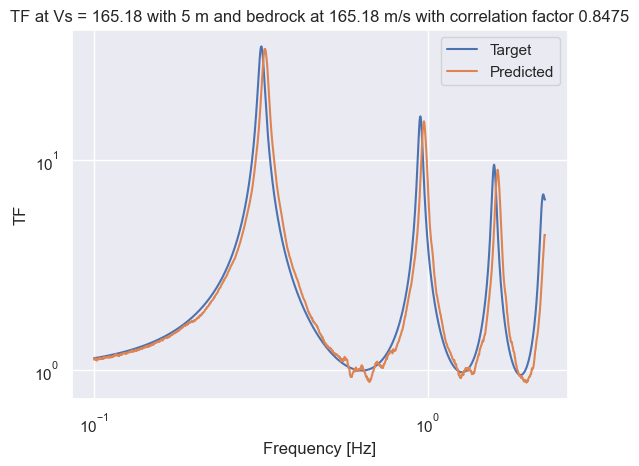

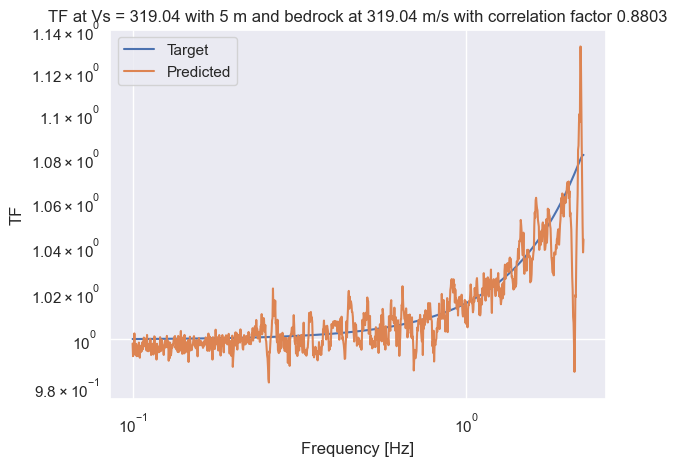

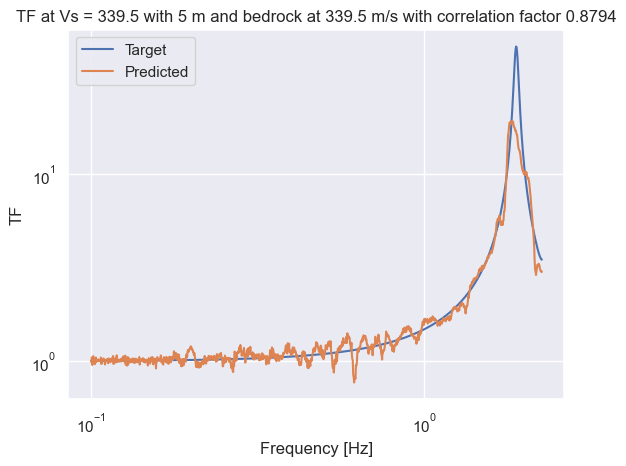

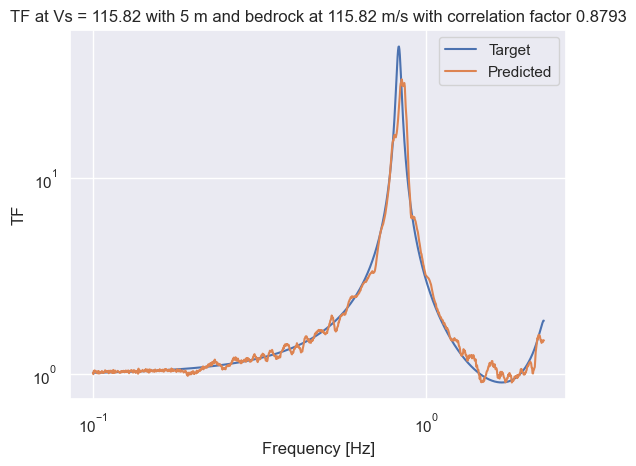

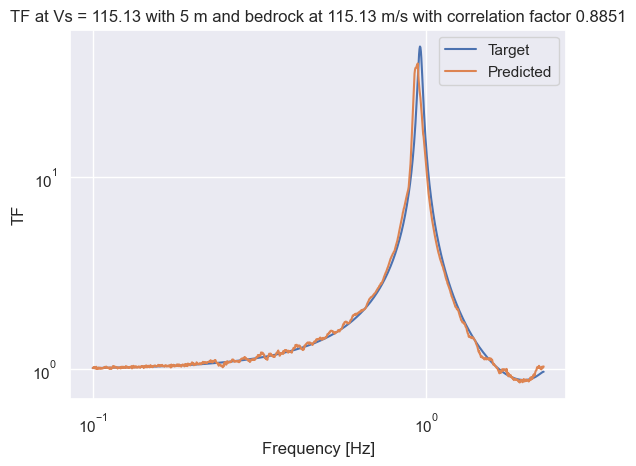

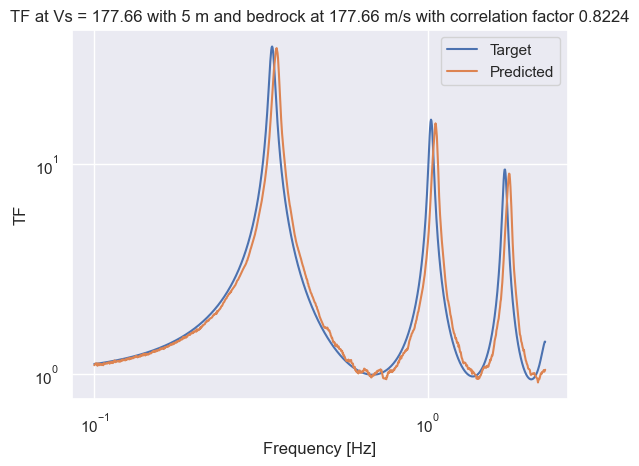

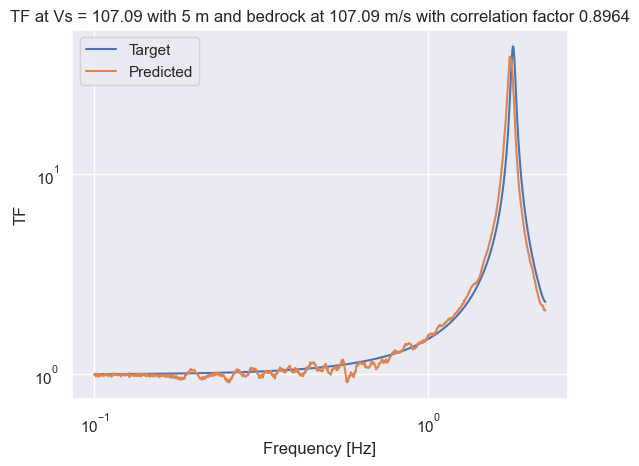

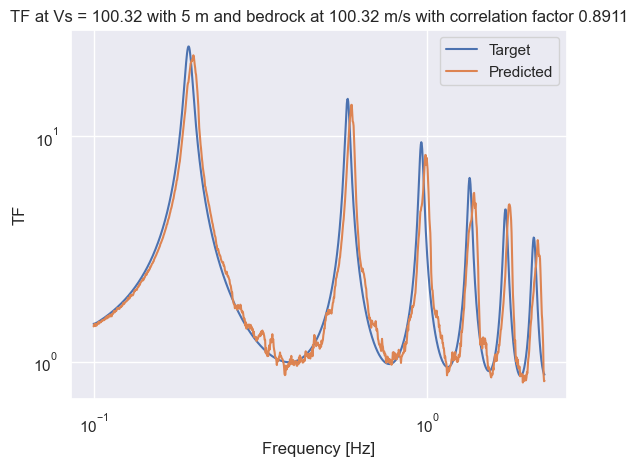

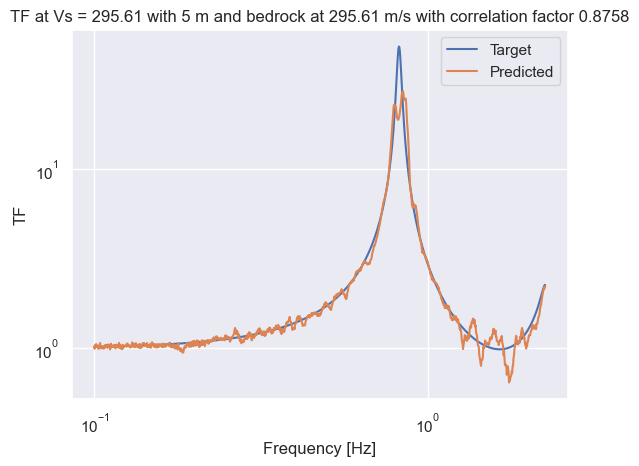

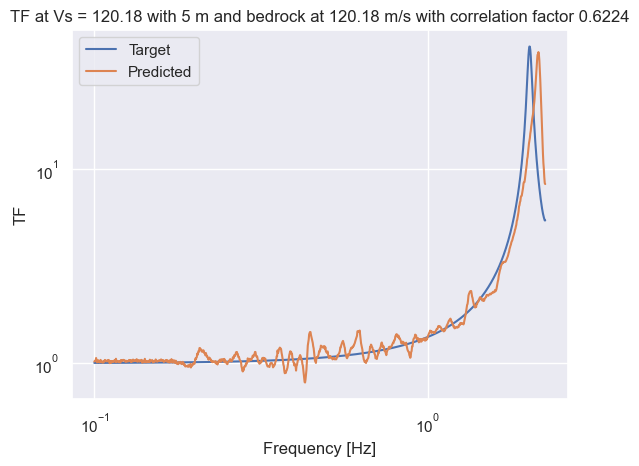

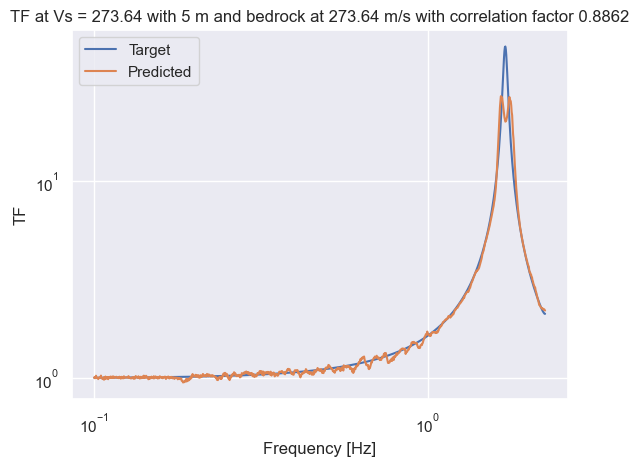

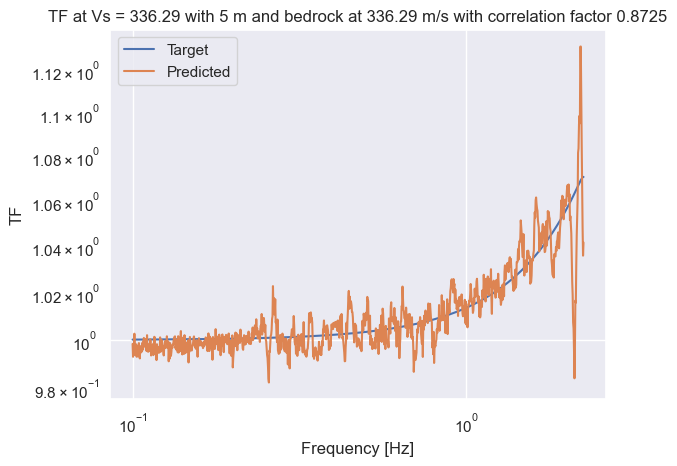

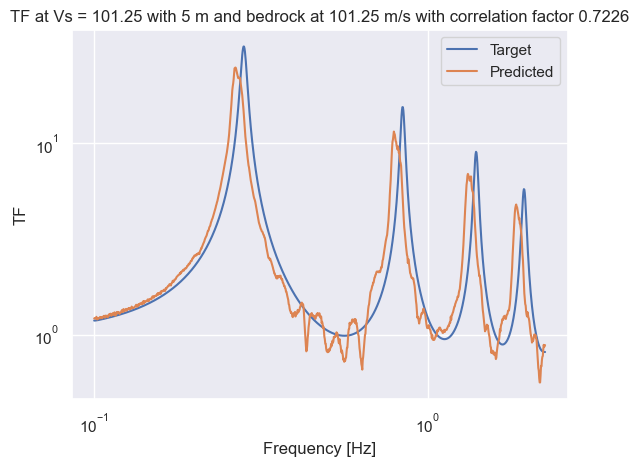

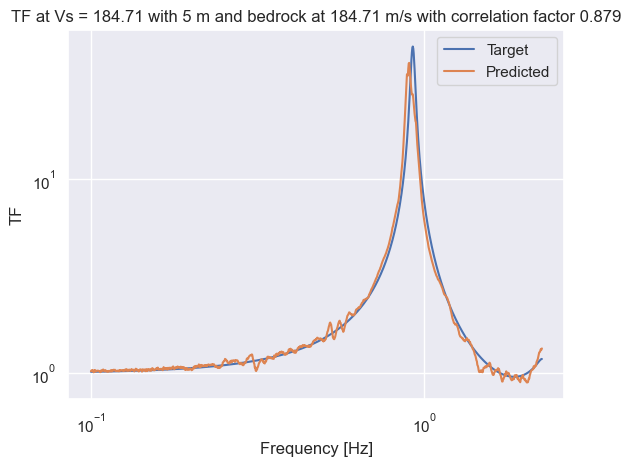

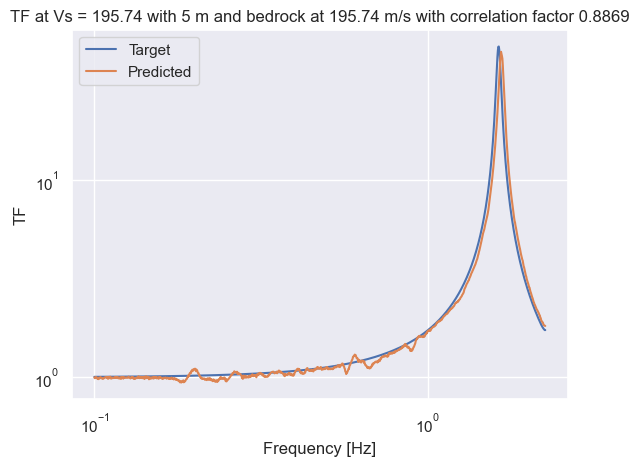

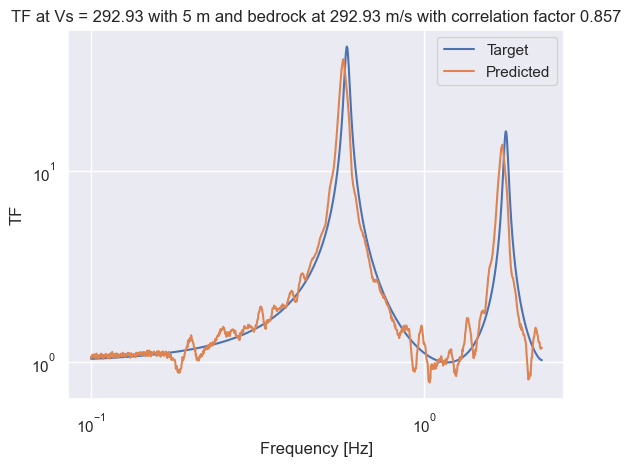

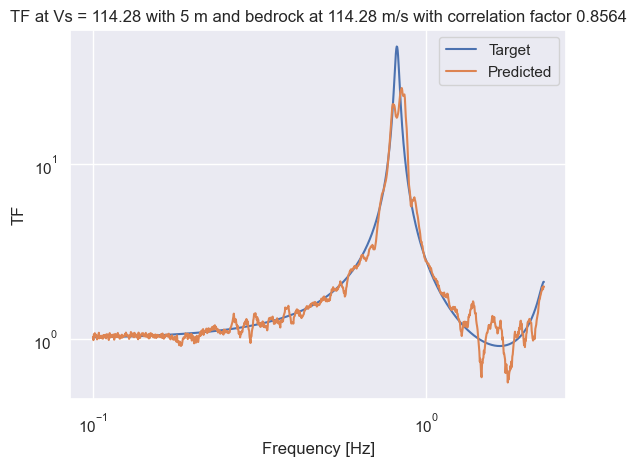

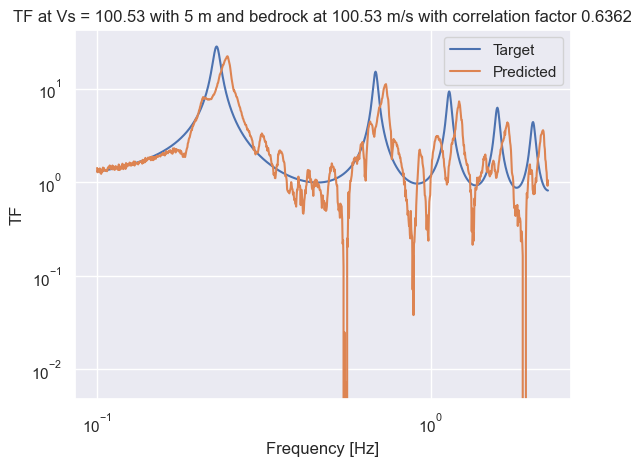

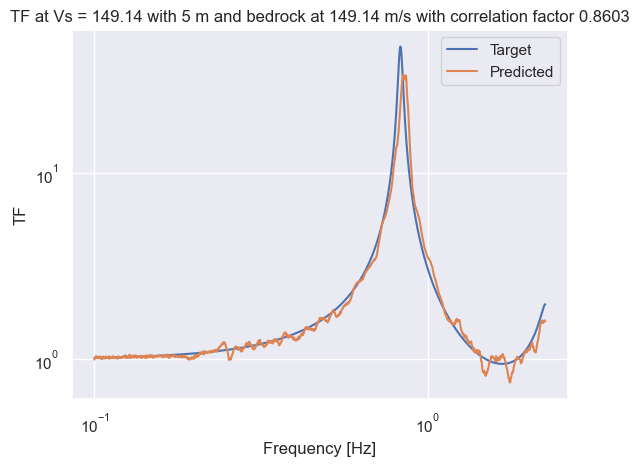

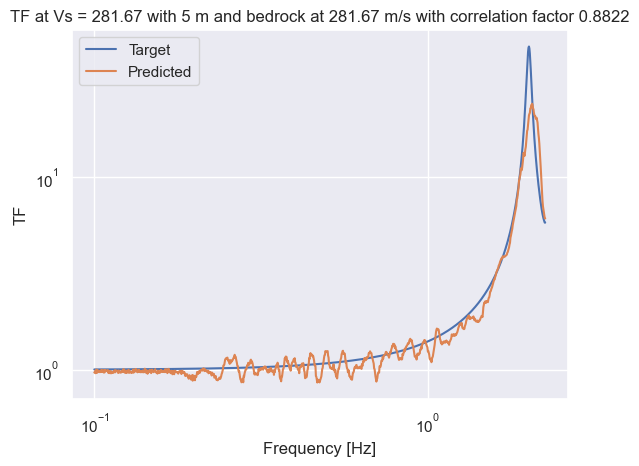

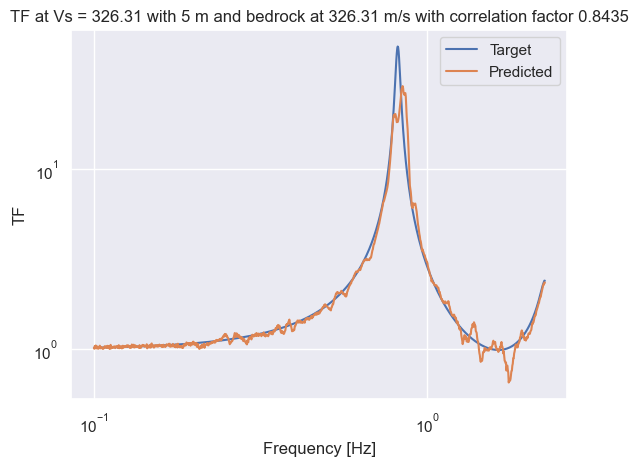

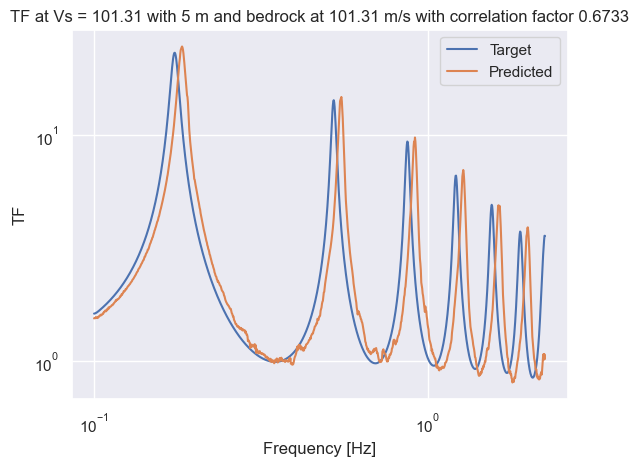

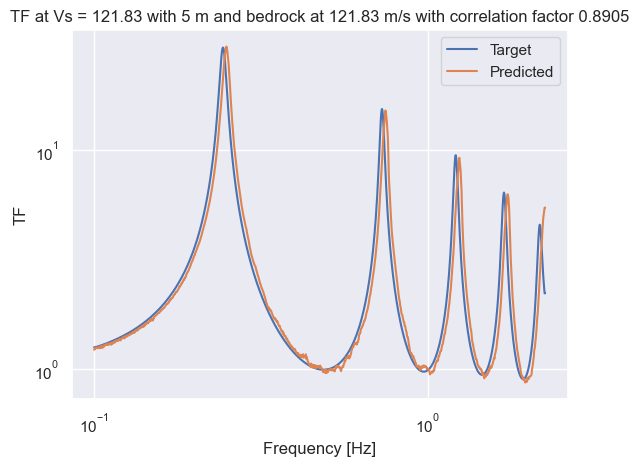

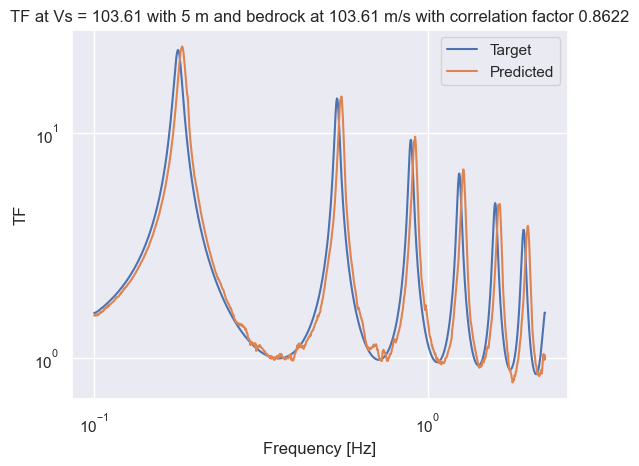

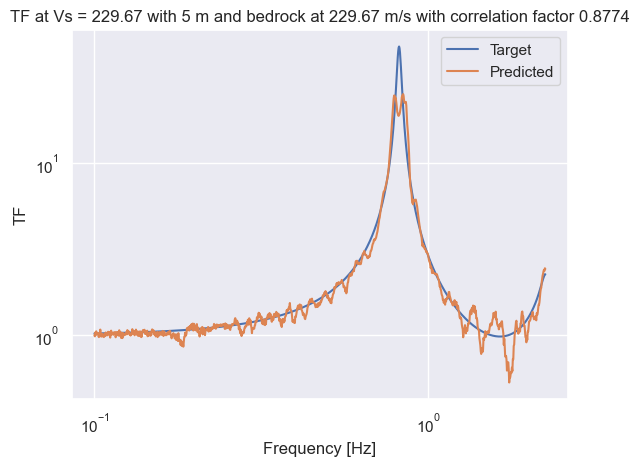

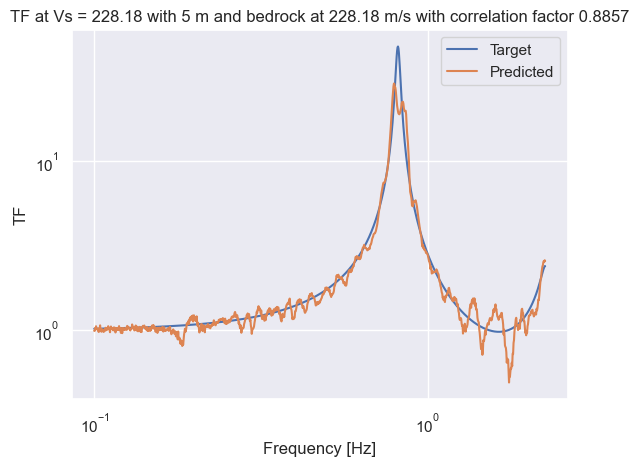

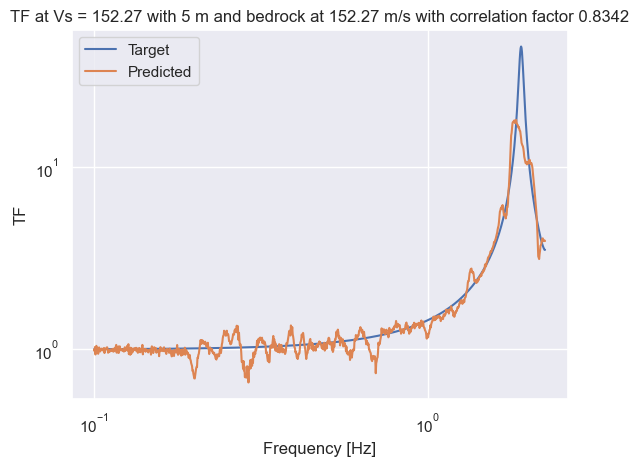

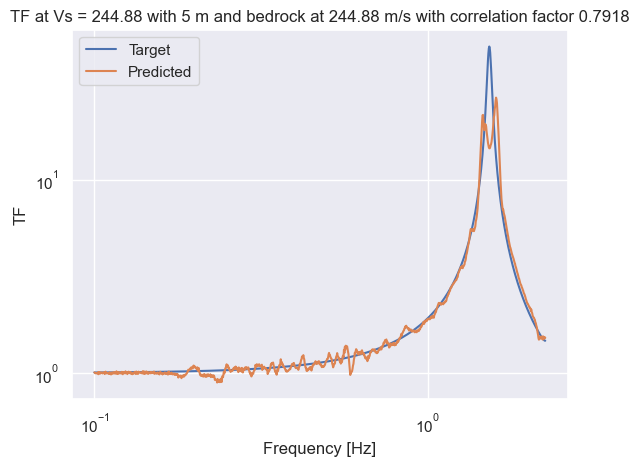

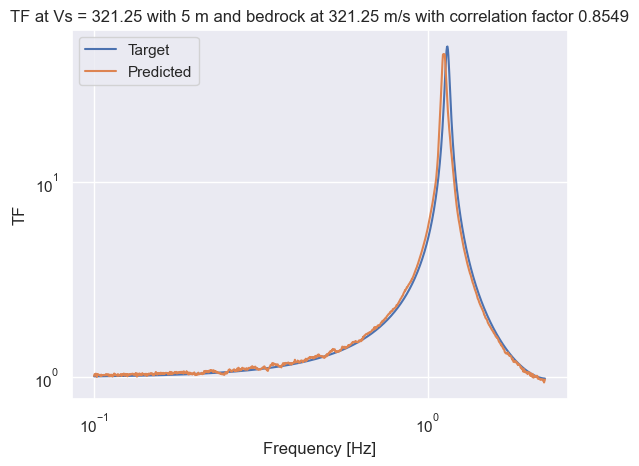

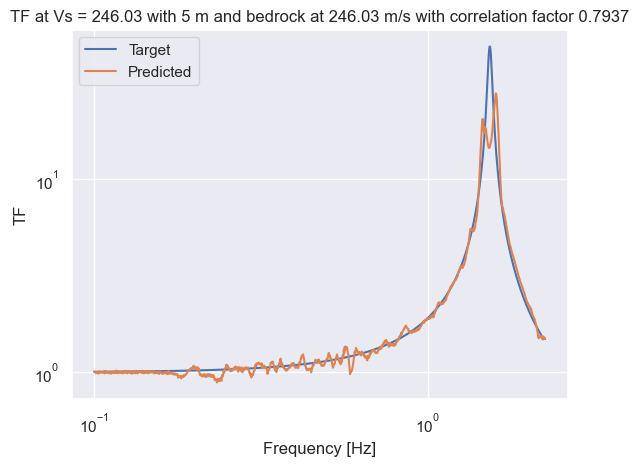

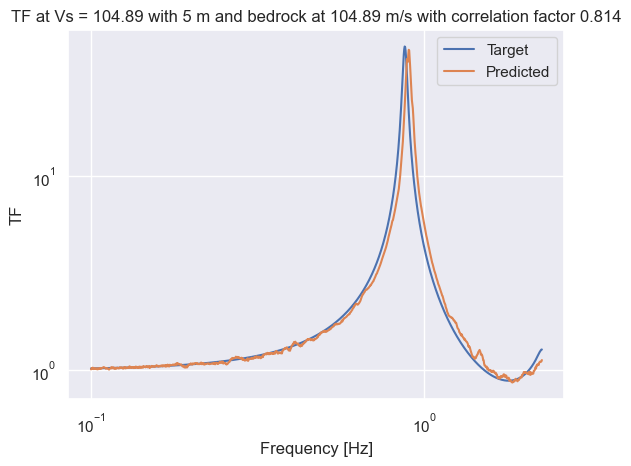

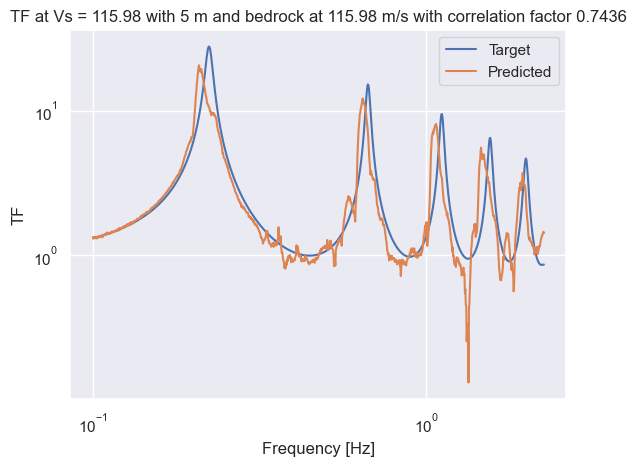

In [63]:
for i in range(target.shape[0]):
    if corr_array[i] < 0.9:
        text_Vs = Vs_data[i,0,:]
        text_Vs = text_Vs[ text_Vs != 0]
        plt.loglog(freq_data, target[i,:], label="Target")
        plt.loglog(freq_data, predicted[i,:], label="Predicted")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("TF")
        plt.title("TF at Vs = " + str(round(text_Vs[0],2)) + " with " + str(len(text_Vs)*5) + " m and bedrock at " + str(round(text_Vs[-1],2)) 
        + " m/s" + " with correlation factor " + str(round(corr_array[i],4)))
        plt.legend()
        plt.show()
    else:
        continue


# Checking

In [64]:
# Create a lodaer for the whole dataset
all_loader = DataLoader(dataset, batch_size=1, shuffle=False)

correlations = []
Vs_soil_range = []
Vs_bedrock_range = []
h_soil = []
predicted = []
target = []

with torch.no_grad():
    for X, y in all_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        if normalized_TTF_data:
            y_pred = denormalization(y_pred)
            y = denormalization(y)
        correlations.append(pearsonr(y.cpu().numpy().flatten(), y_pred.cpu().numpy().flatten())[0])
        text_Vs = X.cpu().numpy().flatten()
        text_Vs = text_Vs[text_Vs != 0]
        Vs_soil_range.append(text_Vs[0])
        h_soil.append(len(text_Vs[:-1])*5)
        Vs_bedrock_range.append(text_Vs[-1])
        predicted.append(y_pred.cpu().numpy().squeeze())
        target.append(y.cpu().numpy().squeeze())

correlations = np.array(correlations)
Vs_soil_range = np.array(Vs_soil_range)
Vs_bedrock_range = np.array(Vs_bedrock_range)
predicted = np.array(predicted)
target = np.array(target)

print(correlations.shape, Vs_soil_range.shape, Vs_bedrock_range.shape, predicted.shape, target.shape)



(1000,) (1000,) (1000,) (1000, 1000) (1000, 1000)


In [65]:
# Save correlation results

np.savetxt(os.path.join(path,"correlations.csv"), correlations, delimiter=",")
np.savetxt(os.path.join(path,"Vs_soil_range.csv"), Vs_soil_range, delimiter=",")
np.savetxt(os.path.join(path,"Vs_bedrock_range.csv"), Vs_bedrock_range, delimiter=",")
np.savetxt(os.path.join(path,"h_soil_range.csv"), h_soil, delimiter=",")

np.savetxt(os.path.join(path, "TTF_target_try_1.csv"), predicted, delimiter=",")

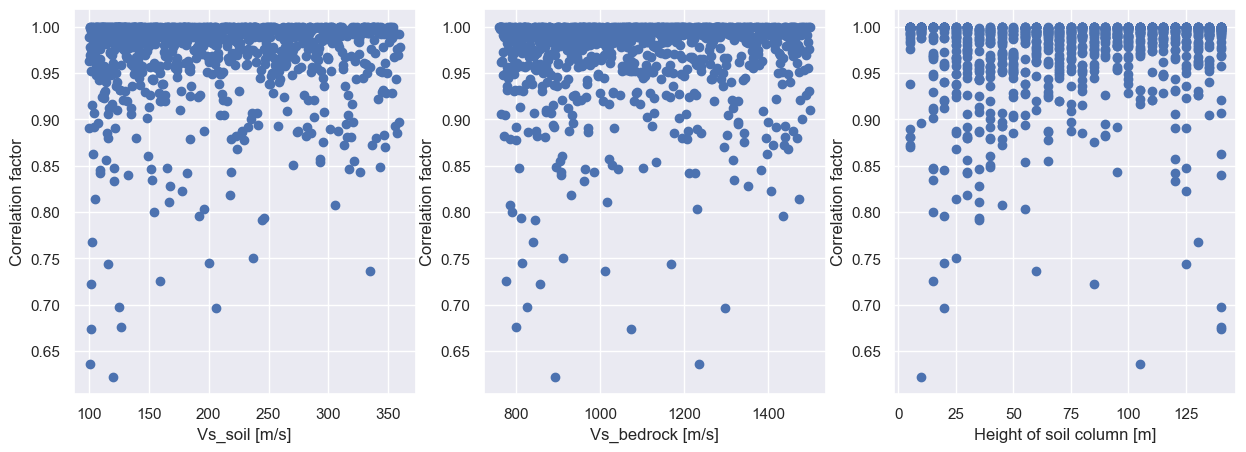

In [66]:
# Plot where x is Vs_soil, Vs_bedrock or height of soil column and y is correlation factor
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(Vs_soil_range, correlations)
ax[0].set_xlabel("Vs_soil [m/s]")
ax[0].set_ylabel("Correlation factor")

ax[1].scatter(Vs_bedrock_range, correlations)
ax[1].set_xlabel("Vs_bedrock [m/s]")
ax[1].set_ylabel("Correlation factor")

ax[2].scatter(h_soil, correlations)
ax[2].set_xlabel("Height of soil column [m]")
ax[2].set_ylabel("Correlation factor")

plt.show()





In [ ]:
# 